# Matching

## Setup

In [1]:
%matplotlib inline

In [2]:
import bz2
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

from IPython.display import display

from chmp.ds import reload
reload('chmp.ds', 'data', 'chmp.app.causality.matching')
from chmp.ds import mpl_set, Object

from chmp.app.causality.matching import match, psmatch

from data import read_rhc_df, normalize_rhc_df

/Volumes/Home/.local/share/virtualenvs/misc-exp-8XcdncOT/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Covariate Matching

Based on lecture "Week 3 / Matching / Data Example" of the coursera course ["A Crash Course in Causality"](https://www.coursera.org/learn/crash-course-in-causality/).


In [3]:
df, meta = read_rhc_df('data/rhc.csv.bz2')
df, meta = normalize_rhc_df(df, meta)

In [4]:
def create_table_one(df, *, strata, smd=True):
    c = df.groupby(strata).agg(['mean', 'std']).transpose().unstack()
    
    if smd:
        c['SMD'] = abs(c[0, 'mean'] - c[1, 'mean']) / np.sqrt(0.5 * (c[0, 'std'] ** 2.0 + c[1, 'std'] ** 2.0))
    
    return c

In [5]:
c_unmatched = create_table_one(df, strata=meta.treatment)
c_unmatched

treatment          0                     1                  SMD
                mean        std       mean        std          
ARF         0.445227   0.497061   0.416209   0.493042  0.058615
CHF         0.069558   0.254436   0.095696   0.294241  0.095027
Cirr        0.049282   0.216486   0.022436   0.148130  0.144734
colcan      0.001690   0.041077   0.000458   0.021398  0.037612
Coma        0.096029   0.294673   0.043498   0.204022  0.207278
COPD        0.112363   0.315857   0.026557   0.160821  0.342364
lungcan     0.009575   0.097395   0.002289   0.047804  0.094965
MOSF        0.067868   0.251555   0.072344   0.259117  0.017528
sepsis      0.148409   0.355555   0.320513   0.466781  0.414797
female      0.460997   0.498547   0.414835   0.492806  0.093127
died        0.629682   0.482958   0.680403   0.466427  0.106834
age        61.760926  17.287674  60.749836  15.630698  0.061352
meanbp1    84.868629  38.874134  68.197802  34.242209  0.455096

In [6]:
indices_0, indices_1 = match(df, treatment=meta.treatment, covariates=meta.covariates)

In [7]:
matched_0 = df.loc[indices_0].reset_index(drop=True)
matched_1 = df.loc[indices_1].reset_index(drop=True)

matched_df = pd.concat([matched_0, matched_1], axis=0, ignore_index=True)
matched_df.sort_index(inplace=True)

In [8]:
c_matched = create_table_one(matched_df, strata=meta.treatment)
c_matched

treatment          0                     1                  SMD
                mean        std       mean        std          
ARF         0.495421   0.500094   0.416209   0.493042  0.159516
CHF         0.095696   0.294241   0.095696   0.294241  0.000000
Cirr        0.022436   0.148130   0.022436   0.148130  0.000000
colcan      0.000458   0.021398   0.000458   0.021398  0.000000
Coma        0.043498   0.204022   0.043498   0.204022  0.000000
COPD        0.026557   0.160821   0.026557   0.160821  0.000000
lungcan     0.002289   0.047804   0.002289   0.047804  0.000000
MOSF        0.072344   0.259117   0.072344   0.259117  0.000000
sepsis      0.241300   0.427970   0.320513   0.466781  0.176894
female      0.437729   0.496221   0.414835   0.492806  0.046295
died        0.623626   0.484586   0.680403   0.466427  0.119380
age        61.167198  16.415684  60.749836  15.630698  0.026040
meanbp1    73.199863  34.134861  68.197802  34.242209  0.146308

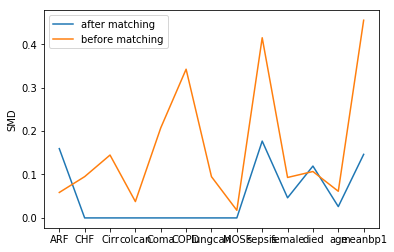

In [9]:
c_matched['SMD'].plot(ax=plt.gca(), label='after matching')
c_unmatched['SMD'].plot(ax=plt.gca(), label='before matching')
mpl_set(
    legend=True, 
    ylabel='SMD', 
    xticks=(np.arange(len(c_matched)), list(c_matched.index)),
)

In [10]:
# compute the contigency table
(
    pd.DataFrame({
    'outcome_1': matched_1[meta.outcome],
    'outcome_0': matched_0[meta.outcome],
    })
    .groupby(['outcome_0', 'outcome_1']).size()
    .unstack()
    .transpose()
)

outcome_0,0,1
outcome_1,,
0,316,382
1,506,980


In [11]:
(matched_1[meta.outcome] - matched_0[meta.outcome]).mean()

0.056776556776556776

## Propensity Scores Matching

Based on lecture "Week 3 / Propensity Scores / Propensity Scores" of the coursera course ["A Crash Course in Causality"](https://www.coursera.org/learn/crash-course-in-causality/).

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
ps_model = LogisticRegression(C=1e3)
ps_model.fit(df[meta.covariates], df[meta.treatment])

ps = ps_model.predict_proba(df[meta.covariates])
ps = pd.Series(ps[:, 1], index=df.index)

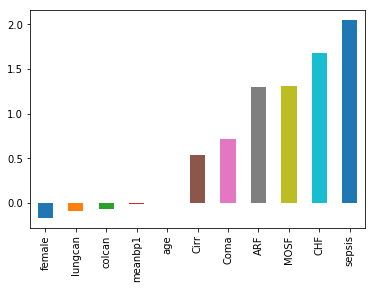

In [14]:
pd.Series(ps_model.coef_[0], index=meta.covariates).sort_values().plot.bar()

In [15]:
indices_0, indices_1 = psmatch(ps, df[meta.treatment])

matched_0 = df.loc[indices_0].reset_index(drop=True)
matched_1 = df.loc[indices_1].reset_index(drop=True)

matched_df = pd.concat([matched_0, matched_1], axis=0, ignore_index=True)
matched_df.sort_index(inplace=True)

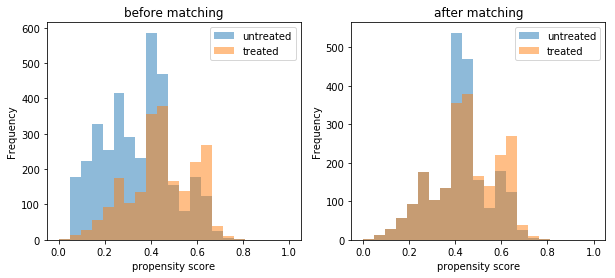

In [16]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plt.sca(ax1)
ps[df[meta.treatment] == 0].plot.hist(alpha=0.5, ax=plt.gca(), label='untreated', range=(0, 1), bins=21)
ps[df[meta.treatment] == 1].plot.hist(alpha=0.5, ax=plt.gca(), label='treated', range=(0, 1), bins=21)
mpl_set(legend=True, title='before matching', xlabel='propensity score')


plt.sca(ax2)
ps.loc[indices_0].plot.hist(alpha=0.5, range=(0, 1), bins=21, label='untreated')
ps.loc[indices_1].plot.hist(alpha=0.5, range=(0, 1), bins=21, label='treated')
mpl_set(legend=True, title='after matching', xlabel='propensity score')

In [17]:
(matched_1[meta.outcome] - matched_0[meta.outcome]).mean()

0.04304029304029304